In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [59]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
import gensim
import pickle
import zipfile
from urllib import request

import numpy as np
import pandas as pd

import seaborn as sns
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Lambda, Add, Concatenate, Multiply, Subtract, Flatten, Dropout

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from gensim.models.doc2vec import Doc2Vec

# Resets notebook state
tf.keras.backend.clear_session()

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
%matplotlib inline

In [3]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(get_available_devices())

Num GPUs Available:  0
['/device:CPU:0', '/device:XLA_CPU:0']


In [4]:
def download(url, filename):
    """Download a file if not present"""
    if not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [5]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/alodokter-recommender/', filename="data.zip")

'data'

In [6]:
n_tag = 1195
n_gender = 2
tag_max_len = 5

def load_users():
    df = pd.read_csv('data/users_20200226.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['user_id', 'gender', 'age']
    
    # insert custom index for word embedding training
    df.insert(0, 'uid', range(1, len(df) + 1))
    return df[['uid', 'user_id', 'gender', 'age']]

def load_articles():
    df = pd.read_csv('data/articles_20200226.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'title', 'tags']
    
    # insert custom index for word embedding training
    df.insert(0, 'pid', range(1, len(df) + 1))
    return df[['pid', 'post_id', 'title', 'tags']]

def load_page_views():
    df = pd.read_csv('data/pageviews_20200226.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['user_id', 'post_id', 'page_views']
    return df

def text2seq(text, n_tag):
    """ using tokenizer to encoded the multi-level categorical feature """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_tag)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=tag_max_len,padding='post')
    return seq

In [7]:
# laki-laki: 1, perempuan: 0
users = load_users()
users['gender'] = users['gender'].apply(lambda x: 1 if (x == 'laki-laki') else 0)
print(users.head())
print("Total Unique Users: {}".format(users.uid.nunique()))

   uid                   user_id  gender  age
0    1  56e27978150cd43518000028       1   40
1    2  56f21377150cd4051e00033a       0   28
2    3  56f2454d150cd44d6c000392       0   39
3    4  56f246a9150cd44d6c0003b4       1   44
4    5  56f2ca34150cd41b0e000021       1   33
Total Unique Users: 113418


In [8]:
articles = load_articles()
print(articles.head())
print("Total Unique Articles: {}".format(articles.pid.nunique()))

   pid  post_id                                              title  \
0    1     1439  Suntik Botox demi Kecantikan  Cek Dulu Keamana...   
1    2     1442            Cara Merawat Kulit Berdasarkan Jenisnya   
2    3     1444          Tandatanda Kehamilan yang Wajib Diketahui   
3    4     1447                    Menghalau Bau Mulut Tidak Sedap   
4    5     1454         Bagaimana Cara Cepat Hamil Setelah Menikah   

                                                tags  
0                             hidup sehat|kecantikan  
1                       hidup sehat|kecantikan|kulit  
2                                 keluarga|kehamilan  
3  kesehatan|asam lambung|bau|gigi|sakit maag|sar...  
4                                 keluarga|kehamilan  
Total Unique Articles: 5738


In [9]:
articles['tags'] = text2seq(articles.tags.values, n_tag=n_tag).tolist()
print(articles.head())
print("Total Unique Articles: {}".format(articles.pid.nunique()))

   pid  post_id                                              title  \
0    1     1439  Suntik Botox demi Kecantikan  Cek Dulu Keamana...   
1    2     1442            Cara Merawat Kulit Berdasarkan Jenisnya   
2    3     1444          Tandatanda Kehamilan yang Wajib Diketahui   
3    4     1447                    Menghalau Bau Mulut Tidak Sedap   
4    5     1454         Bagaimana Cara Cepat Hamil Setelah Menikah   

                      tags  
0          [2, 9, 0, 0, 0]  
1         [2, 9, 12, 0, 0]  
2          [3, 5, 0, 0, 0]  
3  [54, 191, 18, 111, 135]  
4          [3, 5, 0, 0, 0]  
Total Unique Articles: 5738


In [10]:
page_views = load_page_views()
print(page_views.head())
print("Total Unique Users: {}".format(page_views.user_id.nunique()))
print("Total Unique Articles: {}".format(page_views.post_id.nunique()))

                    user_id  post_id  page_views
0  5dfca501636a5b0a9fbf28d8   825969           3
1  5df23e6de9c9580a04f38f5a   463484           3
2  5ded8a90bbde3b0c7fd0079f  1064799           3
3  5e00b0c9e09a800c8ee350fe   485027           3
4  5e0371aa4994dd0c93266a87  1162840           3
Total Unique Users: 113419
Total Unique Articles: 5739


In [11]:
# do some preprocessing to make sure data quality
page_views_clean_1 = page_views.merge(articles, on='post_id', how='left', indicator=True)
page_views_clean_1 = page_views_clean_1[page_views_clean_1._merge != 'left_only']
page_views_clean_1 = page_views_clean_1.astype({'pid': 'int32'})
page_views_clean_1 = page_views_clean_1.drop(['_merge'], axis=1)
page_views_clean_1 = page_views_clean_1[page_views_clean_1.pid.notnull()]
page_views_clean_1

,user_id,post_id,page_views,pid,title,tags
0,5dfca501636a5b0a9fbf28d8,825969,3,3400,Kenali Makanan Penyebab Asam Urat Tinggi Hind...,"[1, 153, 8, 0, 0]"
1,5df23e6de9c9580a04f38f5a,463484,3,2406,Ini Kandungan Salep Penghilang Bekas Luka yang...,"[2, 145, 59, 0, 0]"
2,5ded8a90bbde3b0c7fd0079f,1064799,3,3814,Yuk Cari Tahu Alasan Menurunnya Gairah Seks S...,"[3, 26, 5, 0, 0]"
3,5e00b0c9e09a800c8ee350fe,485027,3,2478,Bahaya Asam Urat jika Tidak Diobati,"[1, 153, 0, 0, 0]"
4,5e0371aa4994dd0c93266a87,1162840,3,4054,Kenali Tandatanda HIV AIDS,"[134, 1, 46, 403, 204]"
...,...,...,...,...,...,...
1973879,5e439d5a0363440b3e117acc,268196,1,1731,Ini Fakta Tentang Darah Haid Hitam yang Perlu ...,"[1, 435, 30, 0, 0]"
1973880,5e439d5a0363440b3e117acc,1161974,1,4034,Berbagai Terapi Alternatif yang Berpeluang Men...,"[3, 52, 5, 15, 0]"
1973881,5e439d5a0363440b3e117acc,761081,1,3250,Ketahui Beragam Fungsi Enzim Renin,"[640, 1, 71, 33, 0]"
1973882,5e439d5a0363440b3e117acc,1162800,1,4049,Waspadai Gejala Maag Kronis dan Komplikasinya,"[1, 54, 172, 111, 132]"


In [12]:
# do some preprocessing to make sure data quality
page_views_clean_2 = page_views_clean_1.merge(users, on='user_id', how='left', indicator=True)
page_views_clean_2 = page_views_clean_2[(page_views_clean_2.uid.notnull()) & (page_views_clean_2.gender.notnull()) & (page_views_clean_2.age.notnull())]
page_views_clean_2 = page_views_clean_2[page_views_clean_2.page_views != 0]
page_views_clean_2 = page_views_clean_2.astype({'uid': 'int32'})
page_views_clean_2 = page_views_clean_2.astype({'age': 'int32'})
page_views_clean_2 = page_views_clean_2.astype({'gender': 'int32'})
page_views_clean_2 = page_views_clean_2.drop(['_merge'], axis=1)
page_views_clean_2

,user_id,post_id,page_views,pid,title,tags,uid,gender,age
0,5dfca501636a5b0a9fbf28d8,825969,3,3400,Kenali Makanan Penyebab Asam Urat Tinggi Hind...,"[1, 153, 8, 0, 0]",43320,0,23
1,5df23e6de9c9580a04f38f5a,463484,3,2406,Ini Kandungan Salep Penghilang Bekas Luka yang...,"[2, 145, 59, 0, 0]",39195,0,23
2,5ded8a90bbde3b0c7fd0079f,1064799,3,3814,Yuk Cari Tahu Alasan Menurunnya Gairah Seks S...,"[3, 26, 5, 0, 0]",38438,0,24
3,5e00b0c9e09a800c8ee350fe,485027,3,2478,Bahaya Asam Urat jika Tidak Diobati,"[1, 153, 0, 0, 0]",47112,0,48
4,5e0371aa4994dd0c93266a87,1162840,3,4054,Kenali Tandatanda HIV AIDS,"[134, 1, 46, 403, 204]",49767,1,29
...,...,...,...,...,...,...,...,...,...
1973769,5e439d5a0363440b3e117acc,268196,1,1731,Ini Fakta Tentang Darah Haid Hitam yang Perlu ...,"[1, 435, 30, 0, 0]",113414,0,40
1973770,5e439d5a0363440b3e117acc,1161974,1,4034,Berbagai Terapi Alternatif yang Berpeluang Men...,"[3, 52, 5, 15, 0]",113414,0,40
1973771,5e439d5a0363440b3e117acc,761081,1,3250,Ketahui Beragam Fungsi Enzim Renin,"[640, 1, 71, 33, 0]",113414,0,40
1973772,5e439d5a0363440b3e117acc,1162800,1,4049,Waspadai Gejala Maag Kronis dan Komplikasinya,"[1, 54, 172, 111, 132]",113414,0,40


#### Final Dataset

In [13]:
dataset = page_views_clean_2
dataset.head(10)

,user_id,post_id,page_views,pid,title,tags,uid,gender,age
0,5dfca501636a5b0a9fbf28d8,825969,3,3400,Kenali Makanan Penyebab Asam Urat Tinggi Hind...,"[1, 153, 8, 0, 0]",43320,0,23
1,5df23e6de9c9580a04f38f5a,463484,3,2406,Ini Kandungan Salep Penghilang Bekas Luka yang...,"[2, 145, 59, 0, 0]",39195,0,23
2,5ded8a90bbde3b0c7fd0079f,1064799,3,3814,Yuk Cari Tahu Alasan Menurunnya Gairah Seks S...,"[3, 26, 5, 0, 0]",38438,0,24
3,5e00b0c9e09a800c8ee350fe,485027,3,2478,Bahaya Asam Urat jika Tidak Diobati,"[1, 153, 0, 0, 0]",47112,0,48
4,5e0371aa4994dd0c93266a87,1162840,3,4054,Kenali Tandatanda HIV AIDS,"[134, 1, 46, 403, 204]",49767,1,29
5,5e06afe9f3ba010c75bddf78,790861,3,3335,Pakai Pil KB Kok Bisa Hamil,"[3, 178, 61, 0, 0]",52769,0,21
6,5e0b16974994dd0c852d5e09,26569,3,343,Cara Menghilangkan Jerawat Batu,"[1, 37, 12, 850, 0]",57254,0,17
7,5dae652a27ea7d0be3b0524b,199787,3,1471,Cari Tahu Berat Janin 6 Bulan yang Normal di Sini,"[3, 5, 0, 0, 0]",30520,0,21
8,5e0d64abe09a800c87e87266,66074,3,542,Cara Mengetahui Masa Subur Wanita,"[19, 5, 61, 15, 213]",59068,1,23
9,5dccc3d9aee7680a4acb3998,203916,3,1496,Berbagai Kemungkinan Penyebab Telat Datang Bul...,"[2, 30, 0, 0, 0]",33729,0,21


In [14]:
num_users = len(dataset.uid.unique())
num_items = len(dataset.pid.unique())
print('There are {} unique users and {} unique articles in this dataset'.format(num_users, num_items))

There are 113418 unique users and 5738 unique articles in this dataset


In [15]:
user_max_id = users.uid.max()
post_max_id = articles.pid.max()
print('There are {} distinct users in page_views and the max of uid is {}'.format(num_users, user_max_id))
print('There are {} distinct articles in page_views and the max of pid is {}'.format(num_items, post_max_id))

There are 113418 distinct users in page_views and the max of uid is 113418
There are 5738 distinct articles in page_views and the max of pid is 5738


#### Creating Model

##### Define Input Layers

In [16]:
def define_input_layers():
    # numerical features
    gen_input = Input((1,), name = 'input_gender')
    num_inputs = [gen_input]
    
    # single level categorical features
    uid_input = Input((1,), name = 'input_uid')
    aid_input = Input((1,), name= 'input_aid')
    cat_sl_inputs = [uid_input, aid_input]
    
    # multi level categorical features (with tag_max_len tags at most)
    tag_input = Input((tag_max_len,), name = 'input_tag')
    cat_ml_inputs = [tag_input]
    
    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    return inputs

inputs = define_input_layers()

In [17]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d(inputs, n_uid, n_aid, n_tag):
    gen_input, uid_input, aid_input, tag_input = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name = 'num_dense_1d_fea4')(gen_input)]
    cat_sl_embed_1d = [Embedding(n_uid + 1, 1, name = 'cat_embed_1d_uid')(uid_input), Embedding(n_aid + 1, 1, name = 'cat_embed_1d_aid')(aid_input)]
    cat_ml_embed_1d = [Embedding(n_tag + 1, 1, mask_zero=True, name = 'cat_embed_1d_tag')(tag_input)]
    
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

#### Graph Diagram
<img src="images/fm_model_1d.png">

In [18]:
def fm_2d(inputs, n_uid, n_aid, n_tag, k):
    gen_input, uid_input, aid_input, tag_input = inputs
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_fea3')(gen_input)] # shape (None, k)
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)
    
    cat_sl_embed_2d = [Embedding(n_uid + 1, k, name = 'cat_embed_2d_uid')(uid_input),
                       Embedding(n_aid + 1, k, name = 'cat_embed_2d_mid')(aid_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_tag + 1, k, name = 'cat_embed_2d_genre')(tag_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_genure_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)
    
    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)
    
    # calcuate the interactions by simplication: sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')
    
    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

#### Graph Diagram
<img src="images/fm_model_2d.png">

In [19]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

#### Graph Diagram
<img src="images/deep_model.png">

In [20]:
def deep_fm_model(n_uid, n_aid, n_tag, k, dnn_dim, dnn_dr):
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_uid, n_aid, n_tag)
    y_fm_2d, embed_2d = fm_2d(inputs, n_uid, n_aid, n_tag, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name = 'deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

#### Graph Diagram
<img src="images/deep_fm_model.png">

In [21]:
params = {
    'n_uid': user_max_id,
    'n_aid': post_max_id,
    'n_tag': 1195,
    'k': 20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}
fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

#### Split Data Into Train/Test

In [22]:
def df2xy(page_views):
    x = [dataset.gender.values,
         dataset.uid.values,
         dataset.pid.values,
         np.concatenate(dataset.tags.values).reshape(-1,tag_max_len)]
    y = dataset.page_views.values
    return x,y

train_data, valid_data = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=99)
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

In [23]:
training = True
if not training and os.path.exists('model/deepfm_weights-gender.h5'):
    deep_fm_model = deep_fm_model.load_weights('model/deepfm_weights-gender.h5')
else:
    # train  model
    with tf.device('/device:CPU:0'):
        deep_fm_model.compile(loss = 'MSE', optimizer=tf.keras.optimizers.Adam(0.001))
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        model_ckp = ModelCheckpoint(filepath='model/deepfm_weights-gender.h5', monitor='val_loss', save_weights_only=True, save_best_only=True)
        callbacks = [model_ckp, early_stop]
        train_history = deep_fm_model.fit(train_x, train_y, epochs=1000, batch_size=4096, validation_split=0.1, callbacks = callbacks)

Train on 1776378 samples, validate on 197376 samples
Epoch 1/1000
1776378/1776378 [==============================] - 16s 9us/sample - loss: 0.3592 - val_loss: 0.1956
Epoch 2/1000
1776378/1776378 [==============================] - 14s 8us/sample - loss: 0.1778 - val_loss: 0.2001
Epoch 3/1000
1776378/1776378 [==============================] - 14s 8us/sample - loss: 0.1750 - val_loss: 0.2065
Epoch 4/1000
1776378/1776378 [==============================] - 14s 8us/sample - loss: 0.1735 - val_loss: 0.2115
Epoch 5/1000
1776378/1776378 [==============================] - 14s 8us/sample - loss: 0.1723 - val_loss: 0.2149
Epoch 6/1000
1776378/1776378 [==============================] - 14s 8us/sample - loss: 0.1712 - val_loss: 0.2178
Epoch 7/1000
1776378/1776378 [==============================] - 14s 8us/sample - loss: 0.1702 - val_loss: 0.2201
Epoch 8/1000
1776378/1776378 [==============================] - 14s 8us/sample - loss: 0.1689 - val_loss: 0.2223
Epoch 9/1000
1776378/1776378 [=============

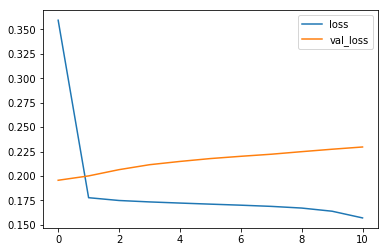

In [24]:
pd.DataFrame(train_history.history).plot()

In [25]:
weights = deep_fm_model.get_weights()
fm_1_weight, fm_2d_weigth, deep_weight = weights[-2]
print("""
contribution of different part of model
    weight of 1st order fm: %5.3f
    weight of 2nd order fm: %5.3f
    weight of dnn part: %5.3f
""" % (fm_1_weight, fm_2d_weigth, deep_weight))


contribution of different part of model
    weight of 1st order fm: 1.205
    weight of 2nd order fm: 0.999
    weight of dnn part: -0.967



##### Model Evaluation

In [26]:
with tf.device('/device:CPU:0'):
    deep_fm_model.evaluate(valid_x, valid_y)

1973754/1973754 [==============================] - 49s 25us/sample - loss: 0.1520


#### Alodokter Articles Clusters

In [31]:
print('loading Doc2Vec model...')
doc2vec_model = Doc2Vec.load('model/doc2vec_20200226.model')
print('loading Doc2Vec model done')

# mapping post_id to doc-index in Doc2Vec Model
post_id_doc_index = {}
for idx in range(len(doc2vec_model.docvecs)):
    post_id_doc_index[doc2vec_model.docvecs.index_to_doctag(idx).split('_')[0]] = idx

print('load KMeans model...')
kmeans_model = pickle.load(open('model/kmeans_20200226.pkl', 'rb'))
print('load KMeans model done')

n_clusters = 16
centroids = kmeans_model.cluster_centers_

# create dictionary doc-id to cluster-id
clusters = kmeans_model.labels_.tolist()
doc_cluster = {(idx, cluster) for idx, cluster in enumerate(clusters)}
cluster_doc = {}
for item in doc_cluster:
    if item[1] in cluster_doc.keys():
        cluster_doc[item[1]].append(item[0])
    else:
        cluster_doc[item[1]] = []
        cluster_doc[item[1]].append(item[0])

loading Doc2Vec model...
loading Doc2Vec model done
load KMeans model...
load KMeans model done


In [38]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)

def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

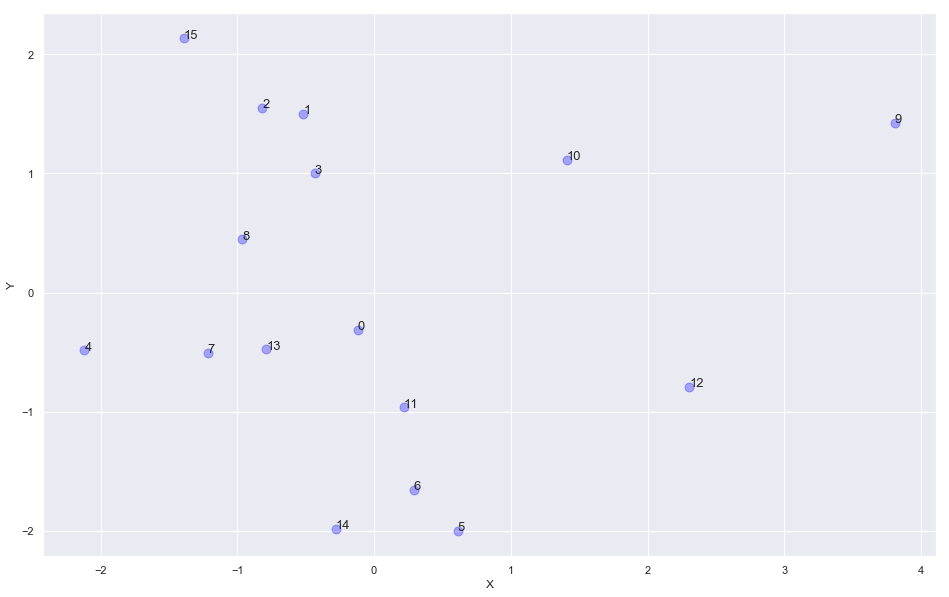

In [53]:
pca_result = PCA(n_components=2).fit_transform(centroids)
ax = plt.figure(figsize=(16,10)).gca()
ax.scatter(
    x=pca_result[:,0],
    y=pca_result[:,1],
    c='blue',
    s=80,
    alpha=0.3,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
for i in range(0, n_clusters):
    ax.annotate(str(i), (pca_result[i:i+1,0], pca_result[i:i+1,1]), fontsize=13)

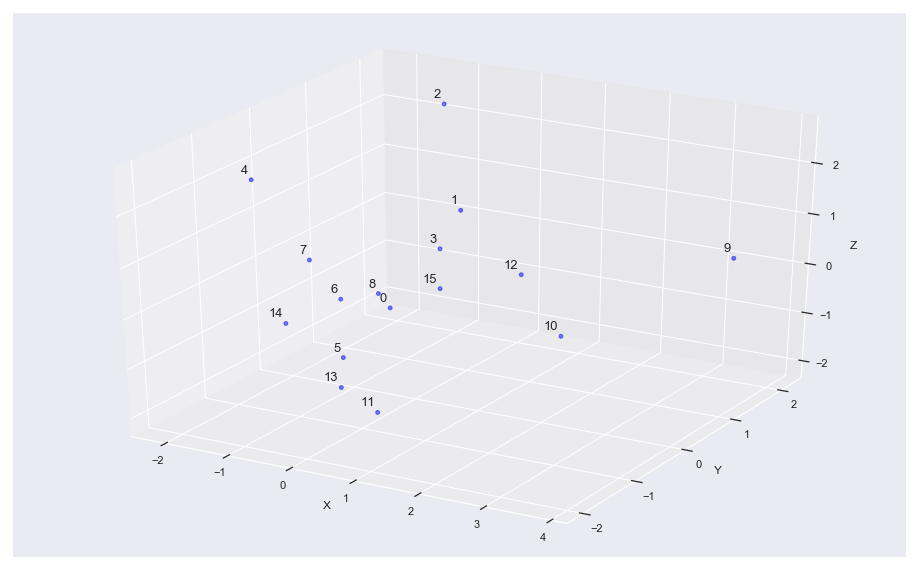

In [54]:
pca_result = PCA(n_components=3).fit_transform(centroids)
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0],
    ys=pca_result[:,1],
    zs=pca_result[:,2],
    c='blue',
    s=15,
    alpha=0.5,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

xyzn = zip(pca_result[:,0], pca_result[:,1], pca_result[:,2])
# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s=str(j), xyz=xyz_, fontsize=13, xytext=(-3,3), textcoords='offset points', ha='right', va='bottom')

##### Testing Plotting Articles from 3 Different Clusters

Text(0,0.5,'Y')

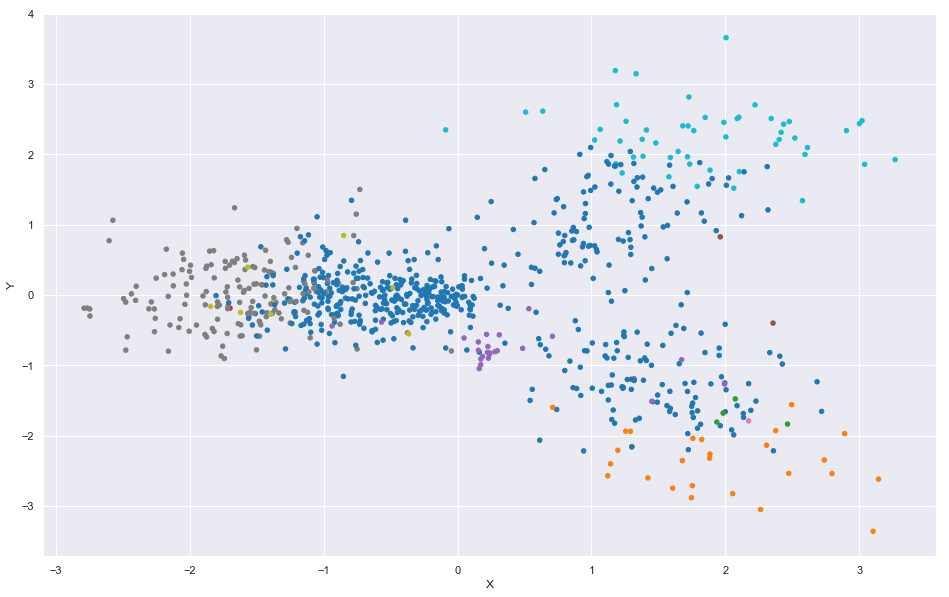

In [55]:
cluster_A = 15
cluster_B = 11
cluster_C = 2
X = [doc2vec_model.docvecs[i] for i in cluster_doc[cluster_A]] + \
    [doc2vec_model.docvecs[i] for i in cluster_doc[cluster_B]] + \
    [doc2vec_model.docvecs[i] for i in cluster_doc[cluster_C]]

Y = kmeans_model.predict(X)
pca_result = PCA(n_components=2).fit_transform(X)

ax = plt.figure(figsize=(16,10)).gca()
ax.scatter(
    x=pca_result[:,0],
    y=pca_result[:,1],
    c=Y,
    s=20,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')

Text(0.5,0,'Z')

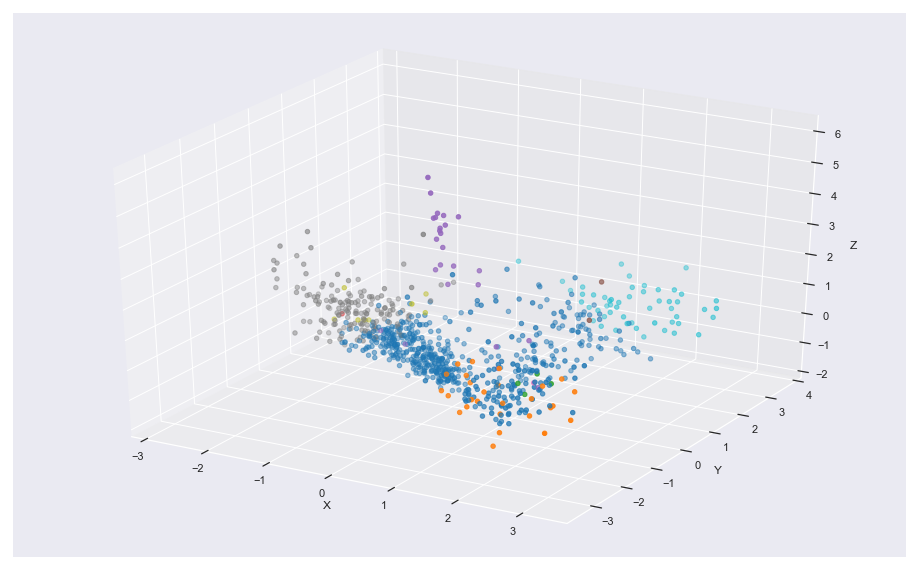

In [56]:
Y = kmeans_model.predict(X)
pca_result = PCA(n_components=3).fit_transform(X)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0],
    ys=pca_result[:,1],
    zs=pca_result[:,2],
    c=Y,
    s=20,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#### Recommendations

In [46]:
uid = 1975
user_preference = dataset[dataset['uid'] == uid].sort_values(by=['page_views'], ascending=False)[:10]
user_preference

,user_id,post_id,page_views,pid,title,tags,uid,gender,age
266452,58c8d707a1faf3111800315c,1046890,2,3782,Obat Batuk Berdahak dan Kering yang Aman Dikon...,"[64, 227, 56, 77, 84]",1975,0,25
266453,58c8d707a1faf3111800315c,1776980,2,5607,Ketahui Lama Penyembuhan Luka Operasi dan Fakt...,"[1, 145, 415, 38, 0]",1975,0,25
266457,58c8d707a1faf3111800315c,1162857,2,4055,Akathisia Efek Samping Obat Antispikotik yang ...,"[779, 22, 395, 121, 306]",1975,0,25
266458,58c8d707a1faf3111800315c,1181573,2,4115,Penyebab Muntah Darah saat Hamil yang Harus Di...,"[54, 172, 5, 111, 132]",1975,0,25
98916,58c8d707a1faf3111800315c,1030008,1,3754,Merokok Vape Tetap Memiliki Risiko Gangguan Ke...,"[554, 1, 89, 74, 17]",1975,0,25
266451,58c8d707a1faf3111800315c,783459,1,3323,Serumen Prop Ketika Kotoran Menutup Saluran T...,"[124, 1, 113, 242, 0]",1975,0,25
266454,58c8d707a1faf3111800315c,105058,1,990,Kebiasaan Ini Bisa Hindarkan Anak dari Flu saa...,"[3, 7, 56, 0, 0]",1975,0,25
266455,58c8d707a1faf3111800315c,541742,1,2641,Tips Berciuman yang Sehat dan Romantis,"[2, 23, 0, 0, 0]",1975,0,25
266456,58c8d707a1faf3111800315c,1787804,1,5646,Bangun Tidur Pusing Mungkin Ini Penyebabnya,"[489, 1, 255, 75, 0]",1975,0,25
266459,58c8d707a1faf3111800315c,1788065,1,5660,Mengenal Fungsi dan Gangguan Kelenjar Paratiroid,"[1, 607, 1173, 0, 0]",1975,0,25


In [60]:
"""
Making recommendations using our trained model is simple.
We only need to feed in a user and all books and then select the books which have the highest predicted ratings for that specific user.
"""
# Creating dataset for making recommendations
article_ids = dataset.pid.unique()
user = [np.array([users[users.uid == uid].gender.values[0] for i in range(len(article_ids))]),
        np.array([users[users.uid == uid].uid.values[0] for i in range(len(article_ids))]),
        article_ids,
        np.array([dataset[dataset.pid == article_ids[i]].tags.values[0] for i in range(len(article_ids))])]
predictions = deep_fm_model.predict(user)
predictions = np.array([a[0] for a in predictions])
recommended_article_ids = (-predictions).argsort()[:20]
recommendations = articles[articles['pid'].isin(recommended_article_ids)]
recommendations

,pid,post_id,title,tags
7,8,1480,Cara Memandikan Bayi yang Wajib Diketahui Oran...,"[3, 6, 552, 0, 0]"
53,54,5687,Olahraga di Masa Kehamilan,"[3, 5, 16, 14, 0]"
246,247,16587,Kelebihan Teknik Bedah Laparoskopi,"[1, 38, 0, 0, 0]"
267,268,18356,Manfaat Madu Secara Medis,"[2, 41, 13, 143, 91]"
269,270,18376,Apa Manfaat Musik dalam Kehamilan,"[3, 6, 5, 137, 0]"
304,305,21949,Kenapa Batuk Berdahak Harus Ditangani secara B...,"[89, 77, 126, 180, 98]"
379,380,32818,Membedakan Muntah pada Bayi yang Normal dan Ab...,"[57, 1, 6, 186, 139]"
405,406,37696,Menghadapi Bayi Cegukan,"[3, 6, 488, 0, 0]"
466,467,51039,Jenis Obat Tidur dan Dampaknya Terhadap Kesehatan,"[1, 45, 192, 34, 50]"
717,718,78268,Mengenali dan Mengatasi Gejala Mata Juling Pad...,"[7, 510, 680, 25, 255]"


Text(0,0.5,'Y')

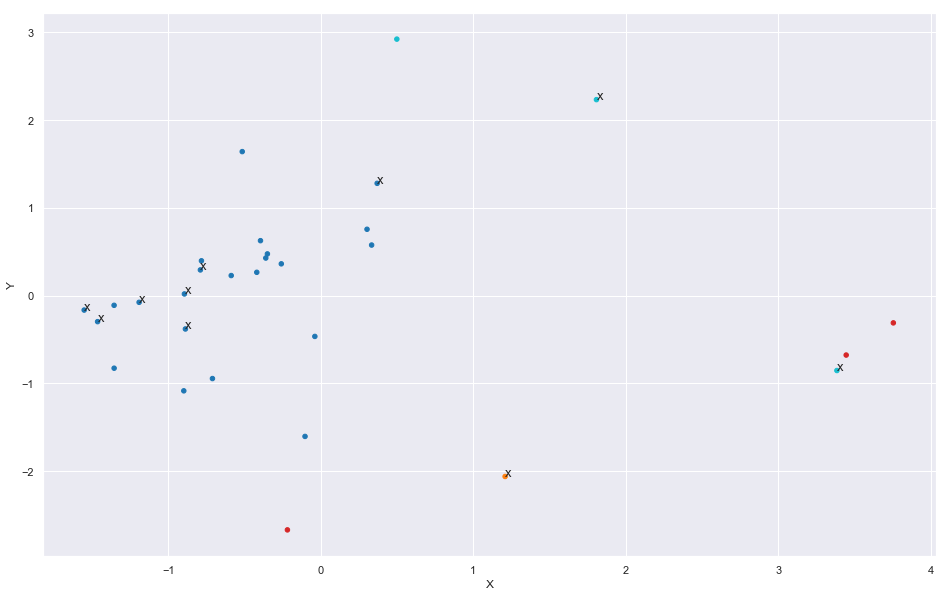

In [61]:
X1 = [doc2vec_model.docvecs[post_id_doc_index[str(post_id)]] for post_id in user_preference['post_id'].tolist()]
Y1 = kmeans_model.predict(X1)
pca_result_1_2d = PCA(n_components=2).fit_transform(X1)

X2 = [doc2vec_model.docvecs[post_id_doc_index[str(post_id)]] for post_id in recommendations['post_id'].tolist()]
Y2 = kmeans_model.predict(X2)
pca_result_2_2d = PCA(n_components=2).fit_transform(X2)

ax = plt.figure(figsize=(16,10)).gca()
ax.scatter(
    x=pca_result_1_2d[:,0],
    y=pca_result_1_2d[:,1],
    c=Y1,
    s=20,
    cmap='tab10'
)
for i in range(0, len(user_preference['post_id'].tolist())):
    ax.annotate('x', (pca_result_1_2d[i:i+1,0], pca_result_1_2d[i:i+1,1]), fontsize=13)

ax.scatter(
    x=pca_result_2_2d[:,0],
    y=pca_result_2_2d[:,1],
    c=Y2,
    s=20,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')

Text(0.5,0,'Z')

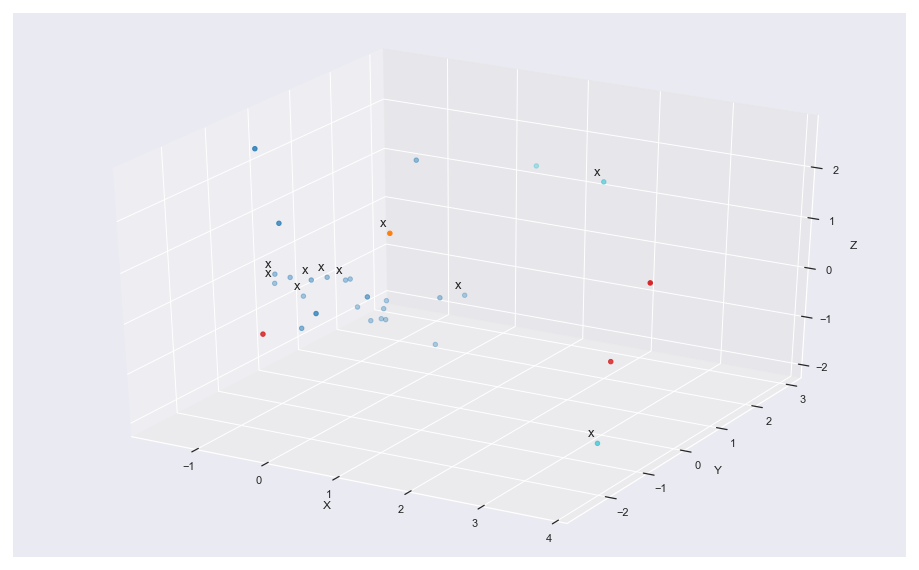

In [62]:
Y1 = kmeans_model.predict(X1)
pca_result_1_3d = PCA(n_components=3).fit_transform(X1)

Y2 = kmeans_model.predict(X2)
pca_result_2_3d = PCA(n_components=3).fit_transform(X2)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result_1_3d[:,0],
    ys=pca_result_1_3d[:,1],
    zs=pca_result_1_3d[:,2],
    c=Y1,
    s=20,
    cmap='tab10'
)
xyzn = zip(pca_result_1_3d[:,0], pca_result_1_3d[:,1], pca_result_1_3d[:,2])
# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s='x', xyz=xyz_, fontsize=13, xytext=(-3,3), textcoords='offset points', ha='right', va='bottom')

ax.scatter(
    xs=pca_result_2_3d[:,0],
    ys=pca_result_2_3d[:,1],
    zs=pca_result_2_3d[:,2],
    c=Y2,
    s=20,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')